<a href="https://colab.research.google.com/github/francesco-univr/Customer-Segmentation-with-PCA-K-means/blob/main/Spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import delle librerie necessarie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Configurazione visualizzazione
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Caricamento dataset
print("🎵 Caricamento Dataset Spotify...")
url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv"
df = pd.read_csv(url)

print(f"\n📊 Dimensioni dataset: {df.shape}")
print(f"Numero di canzoni: {df.shape[0]:,}")
print(f"Numero di features: {df.shape[1]}")

🎵 Caricamento Dataset Spotify...

📊 Dimensioni dataset: (32833, 23)
Numero di canzoni: 32,833
Numero di features: 23


In [ ]:
# Informazioni sul dataset
print("\n📋 Informazioni Dataset:")
print(df.info())

print("\n🎵 Prime 5 righe:")
print(df.head())

# Colonne disponibili
print("\n📝 Colonne disponibili:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")


📋 Informazioni Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-

In [ ]:
# Features audio per il clustering
audio_features = [
    'danceability',      # Quanto è ballabile (0-1)
    'energy',           # Intensità energetica (0-1)
    'loudness',         # Volume in decibel
    'speechiness',      # Presenza di parlato (0-1)
    'acousticness',     # Livello acustico (0-1)
    'instrumentalness', # Assenza di voce (0-1)
    'liveness',         # Presenza di pubblico (0-1)
    'valence',          # Positività musicale (0-1)
    'tempo'             # Velocità in BPM
]

# Statistiche descrittive
print("\n📊 Statistiche Features Audio:")
print(df[audio_features].describe().round(3))

# Controlla valori mancanti
print("\n❓ Valori mancanti per feature:")
missing = df[audio_features].isnull().sum()
print(missing[missing > 0])


📊 Statistiche Features Audio:
       danceability     energy   loudness  speechiness  acousticness  \
count     32833.000  32833.000  32833.000    32833.000     32833.000   
mean          0.655      0.699     -6.719        0.107         0.175   
std           0.145      0.181      2.988        0.101         0.220   
min           0.000      0.000    -46.448        0.000         0.000   
25%           0.563      0.581     -8.171        0.041         0.015   
50%           0.672      0.721     -6.166        0.062         0.080   
75%           0.761      0.840     -4.645        0.132         0.255   
max           0.983      1.000      1.275        0.918         0.994   

       instrumentalness   liveness    valence      tempo  
count         32833.000  32833.000  32833.000  32833.000  
mean              0.085      0.190      0.511    120.881  
std               0.224      0.154      0.233     26.904  
min               0.000      0.000      0.000      0.000  
25%               0.000  

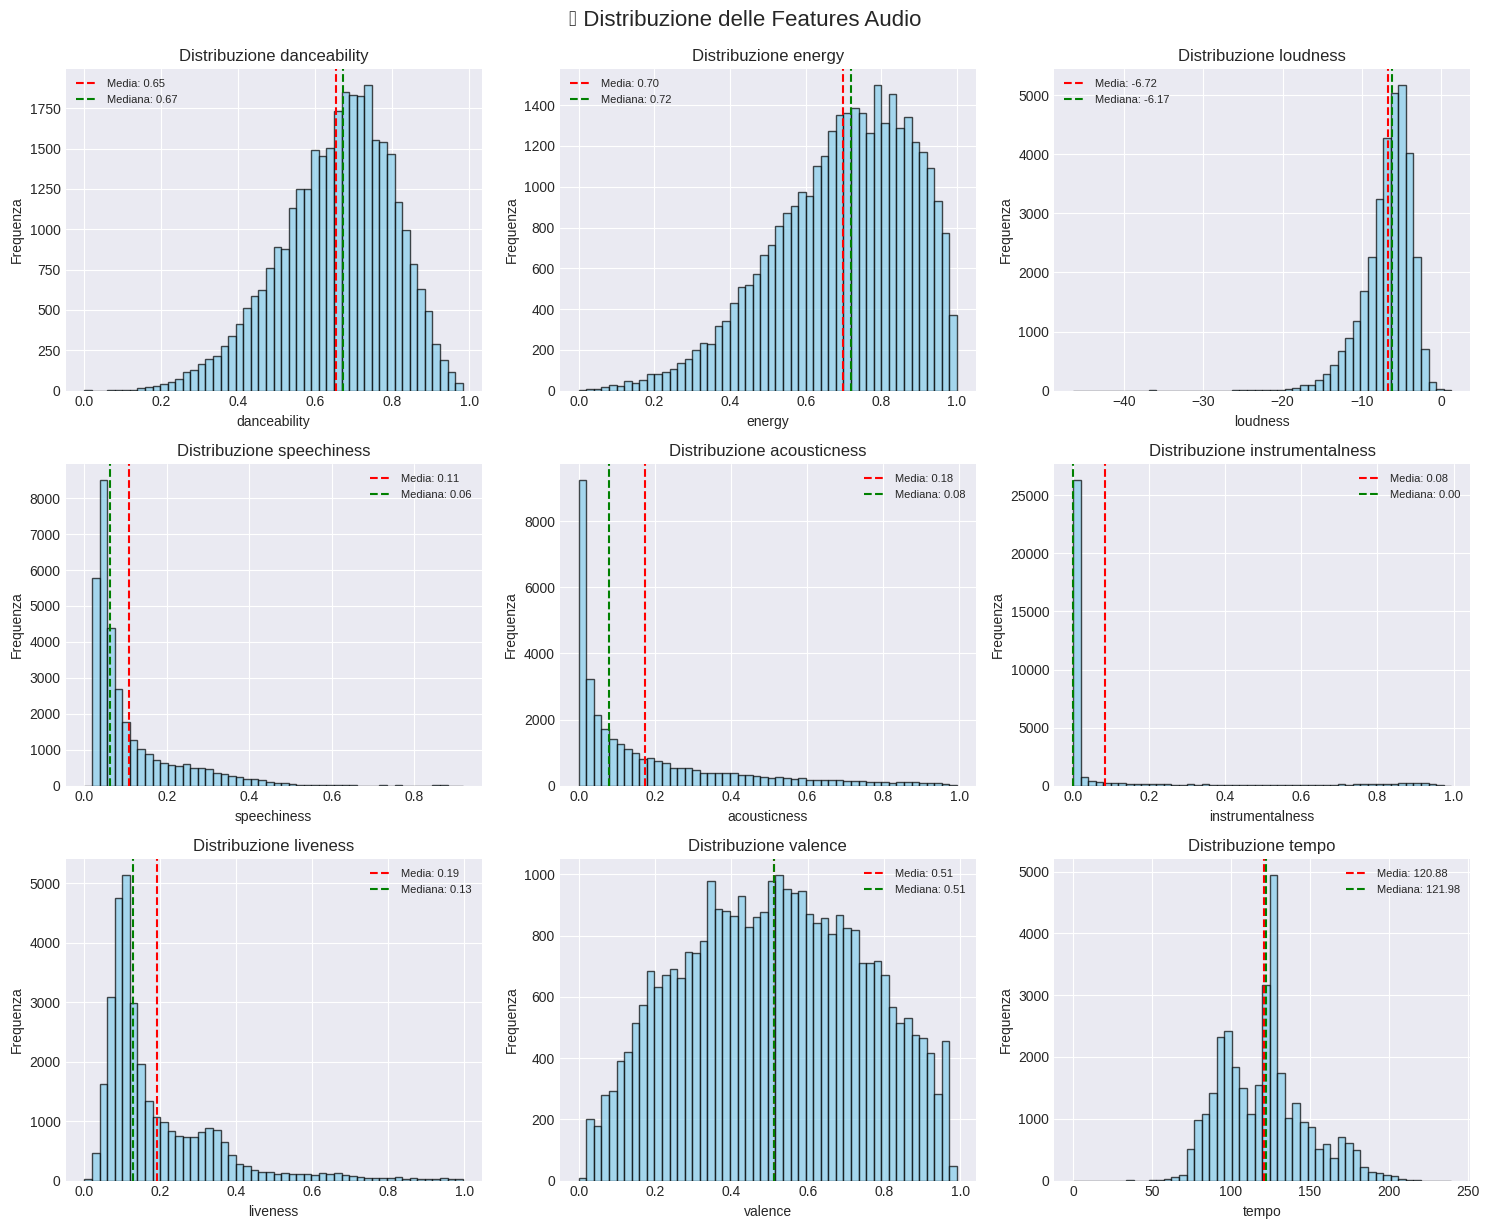

In [ ]:
# Visualizzazione distribuzioni
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, feature in enumerate(audio_features):
    axes[idx].hist(df[feature].dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[idx].set_title(f'Distribuzione {feature}', fontsize=12)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequenza')

    # Aggiungi statistiche
    mean_val = df[feature].mean()
    median_val = df[feature].median()
    axes[idx].axvline(mean_val, color='red', linestyle='--', label=f'Media: {mean_val:.2f}')
    axes[idx].axvline(median_val, color='green', linestyle='--', label=f'Mediana: {median_val:.2f}')
    axes[idx].legend(fontsize=8)

plt.tight_layout()
plt.suptitle('📊 Distribuzione delle Features Audio', fontsize=16, y=1.02)
plt.show()

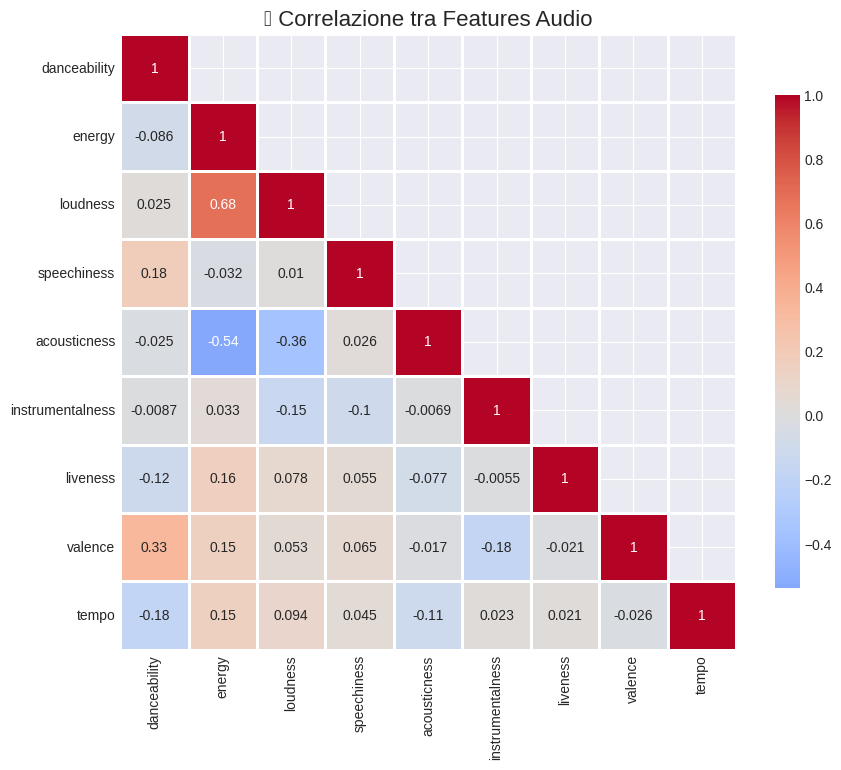


🔗 Correlazioni più significative (|r| > 0.3):
danceability <-> valence: 0.331
energy <-> loudness: 0.677
energy <-> acousticness: -0.540
loudness <-> acousticness: -0.362


In [ ]:
# Correlazione tra features
plt.figure(figsize=(10, 8))
correlation_matrix = df[audio_features].corr()
mask = np.triu(np.ones_like(correlation_matrix), k=1)
sns.heatmap(correlation_matrix,
            mask=mask,
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('🔗 Correlazione tra Features Audio', fontsize=16)
plt.show()

# Correlazioni più forti
print("\n🔗 Correlazioni più significative (|r| > 0.3):")
for i in range(len(correlation_matrix)):
    for j in range(i+1, len(correlation_matrix)):
        if abs(correlation_matrix.iloc[i, j]) > 0.3:
            print(f"{correlation_matrix.index[i]} <-> {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]:.3f}")

In [ ]:
# Rimuovi righe con valori mancanti
df_clean = df.dropna(subset=audio_features).copy()
print(f"\n✅ Dataset pulito: {df_clean.shape[0]:,} canzoni")

# Estrai features per clustering
X = df_clean[audio_features].values

# Normalizzazione (importante per clustering!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\n📏 Verifica normalizzazione:")
print("Media per feature (dovrebbe essere ~0):", np.mean(X_scaled, axis=0).round(3))
print("Std per feature (dovrebbe essere ~1):", np.std(X_scaled, axis=0).round(3))


✅ Dataset pulito: 32,833 canzoni

📏 Verifica normalizzazione:
Media per feature (dovrebbe essere ~0): [ 0.  0.  0. -0.  0. -0.  0.  0.  0.]
Std per feature (dovrebbe essere ~1): [1. 1. 1. 1. 1. 1. 1. 1. 1.]



🔍 Calcolo metriche per diversi K...
K=2: Inertia=250546, Silhouette=0.189
K=3: Inertia=223140, Silhouette=0.140
K=4: Inertia=202132, Silhouette=0.152
K=5: Inertia=184009, Silhouette=0.155
K=6: Inertia=171250, Silhouette=0.159
K=7: Inertia=161564, Silhouette=0.146
K=8: Inertia=153899, Silhouette=0.142
K=9: Inertia=147893, Silhouette=0.147
K=10: Inertia=142692, Silhouette=0.147


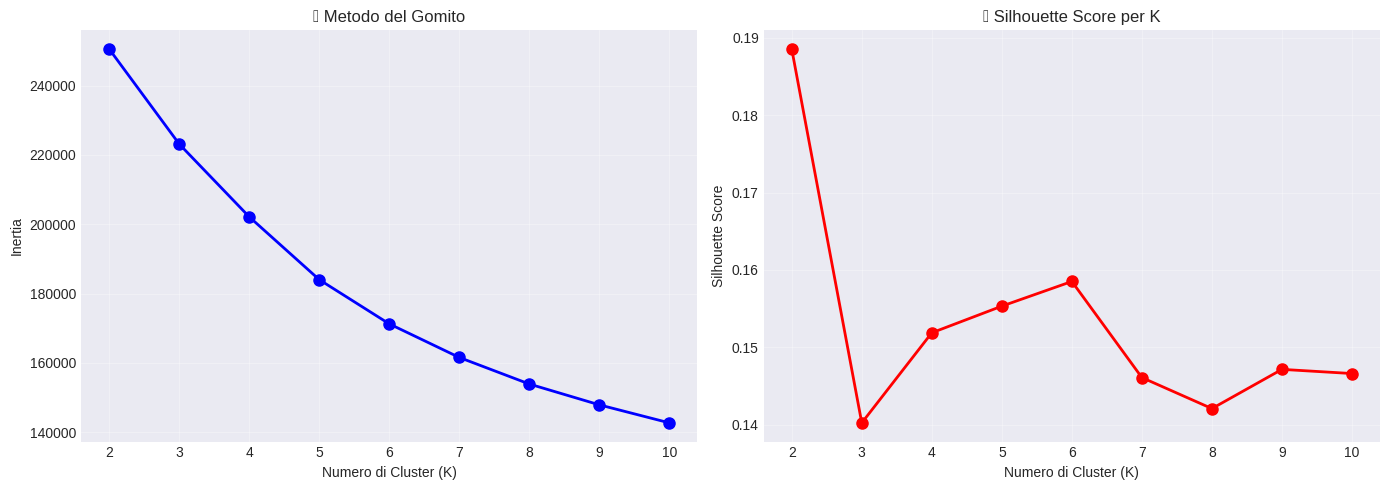


💡 K ottimale basato su Silhouette Score: 2


In [ ]:
# Metodo del gomito
inertias = []
silhouette_scores = []
K_range = range(2, 11)

print("\n🔍 Calcolo metriche per diversi K...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

    print(f"K={k}: Inertia={kmeans.inertia_:.0f}, Silhouette={silhouette_scores[-1]:.3f}")

# Visualizzazione
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Numero di Cluster (K)')
ax1.set_ylabel('Inertia')
ax1.set_title('📈 Metodo del Gomito')
ax1.grid(True, alpha=0.3)

# Silhouette plot
ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Numero di Cluster (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('📊 Silhouette Score per K')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Suggerimento
best_k = K_range[np.argmax(silhouette_scores)]
print(f"\n💡 K ottimale basato su Silhouette Score: {best_k}")

In [ ]:
# Applica K-means con il K ottimale
optimal_k = 5  # Puoi modificare basandoti sui risultati sopra
print(f"\n🎯 Applicazione K-means con K={optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
df_clean['Cluster'] = kmeans.fit_predict(X_scaled)

# Statistiche cluster
print("\n📊 Distribuzione canzoni per cluster:")
cluster_counts = df_clean['Cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count:,} canzoni ({count/len(df_clean)*100:.1f}%)")


🎯 Applicazione K-means con K=5

📊 Distribuzione canzoni per cluster:
Cluster 0: 9,171 canzoni (27.9%)
Cluster 1: 11,606 canzoni (35.3%)
Cluster 2: 4,894 canzoni (14.9%)
Cluster 3: 2,552 canzoni (7.8%)
Cluster 4: 4,610 canzoni (14.0%)


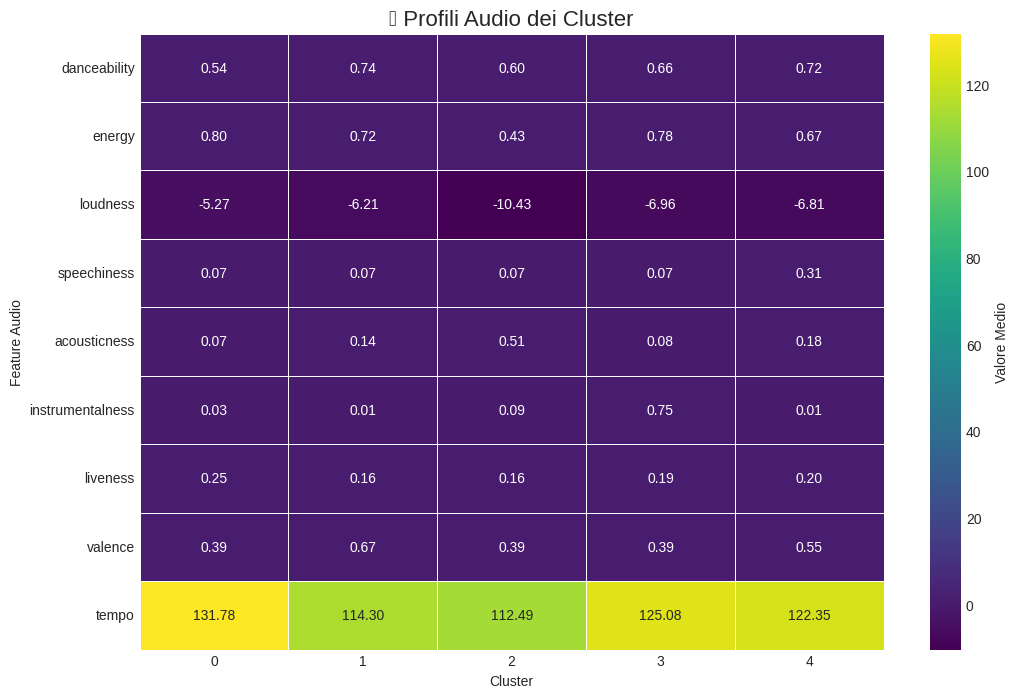


🎭 Interpretazione dei Cluster:


🎵 CLUSTER 0:
Caratteristiche principali:
  ↑ energy: 0.801 (sopra la media)
  ↓ valence: 0.386 (sotto la media)
  ↓ danceability: 0.543 (sotto la media)

🎵 CLUSTER 1:
Caratteristiche principali:
  ↑ valence: 0.672 (sopra la media)
  ↑ danceability: 0.737 (sopra la media)

🎵 CLUSTER 2:
Caratteristiche principali:
  ↑ acousticness: 0.509 (sopra la media)
  ↓ valence: 0.391 (sotto la media)
  ↓ loudness: -10.435 (sotto la media)
  ↓ energy: 0.430 (sotto la media)

🎵 CLUSTER 3:
Caratteristiche principali:
  ↑ instrumentalness: 0.747 (sopra la media)
  ↓ valence: 0.386 (sotto la media)

🎵 CLUSTER 4:
Caratteristiche principali:
  ↑ speechiness: 0.312 (sopra la media)


In [ ]:
# Calcola profili medi per cluster
cluster_profiles = df_clean.groupby('Cluster')[audio_features].mean()

# Visualizzazione profili
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_profiles.T,
            cmap='viridis',
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'Valore Medio'},
            linewidths=0.5)
plt.title('🎵 Profili Audio dei Cluster', fontsize=16)
plt.xlabel('Cluster')
plt.ylabel('Feature Audio')
plt.show()

# Interpretazione cluster
print("\n🎭 Interpretazione dei Cluster:\n")
for cluster in range(optimal_k):
    profile = cluster_profiles.loc[cluster]
    print(f"\n🎵 CLUSTER {cluster}:")
    print(f"Caratteristiche principali:")

    # Trova features dominanti
    z_scores = (profile - df_clean[audio_features].mean()) / df_clean[audio_features].std()
    dominant = z_scores[abs(z_scores) > 0.5].sort_values(ascending=False)

    for feature, z_score in dominant.items():
        if z_score > 0:
            print(f"  ↑ {feature}: {profile[feature]:.3f} (sopra la media)")
        else:
            print(f"  ↓ {feature}: {profile[feature]:.3f} (sotto la media)")

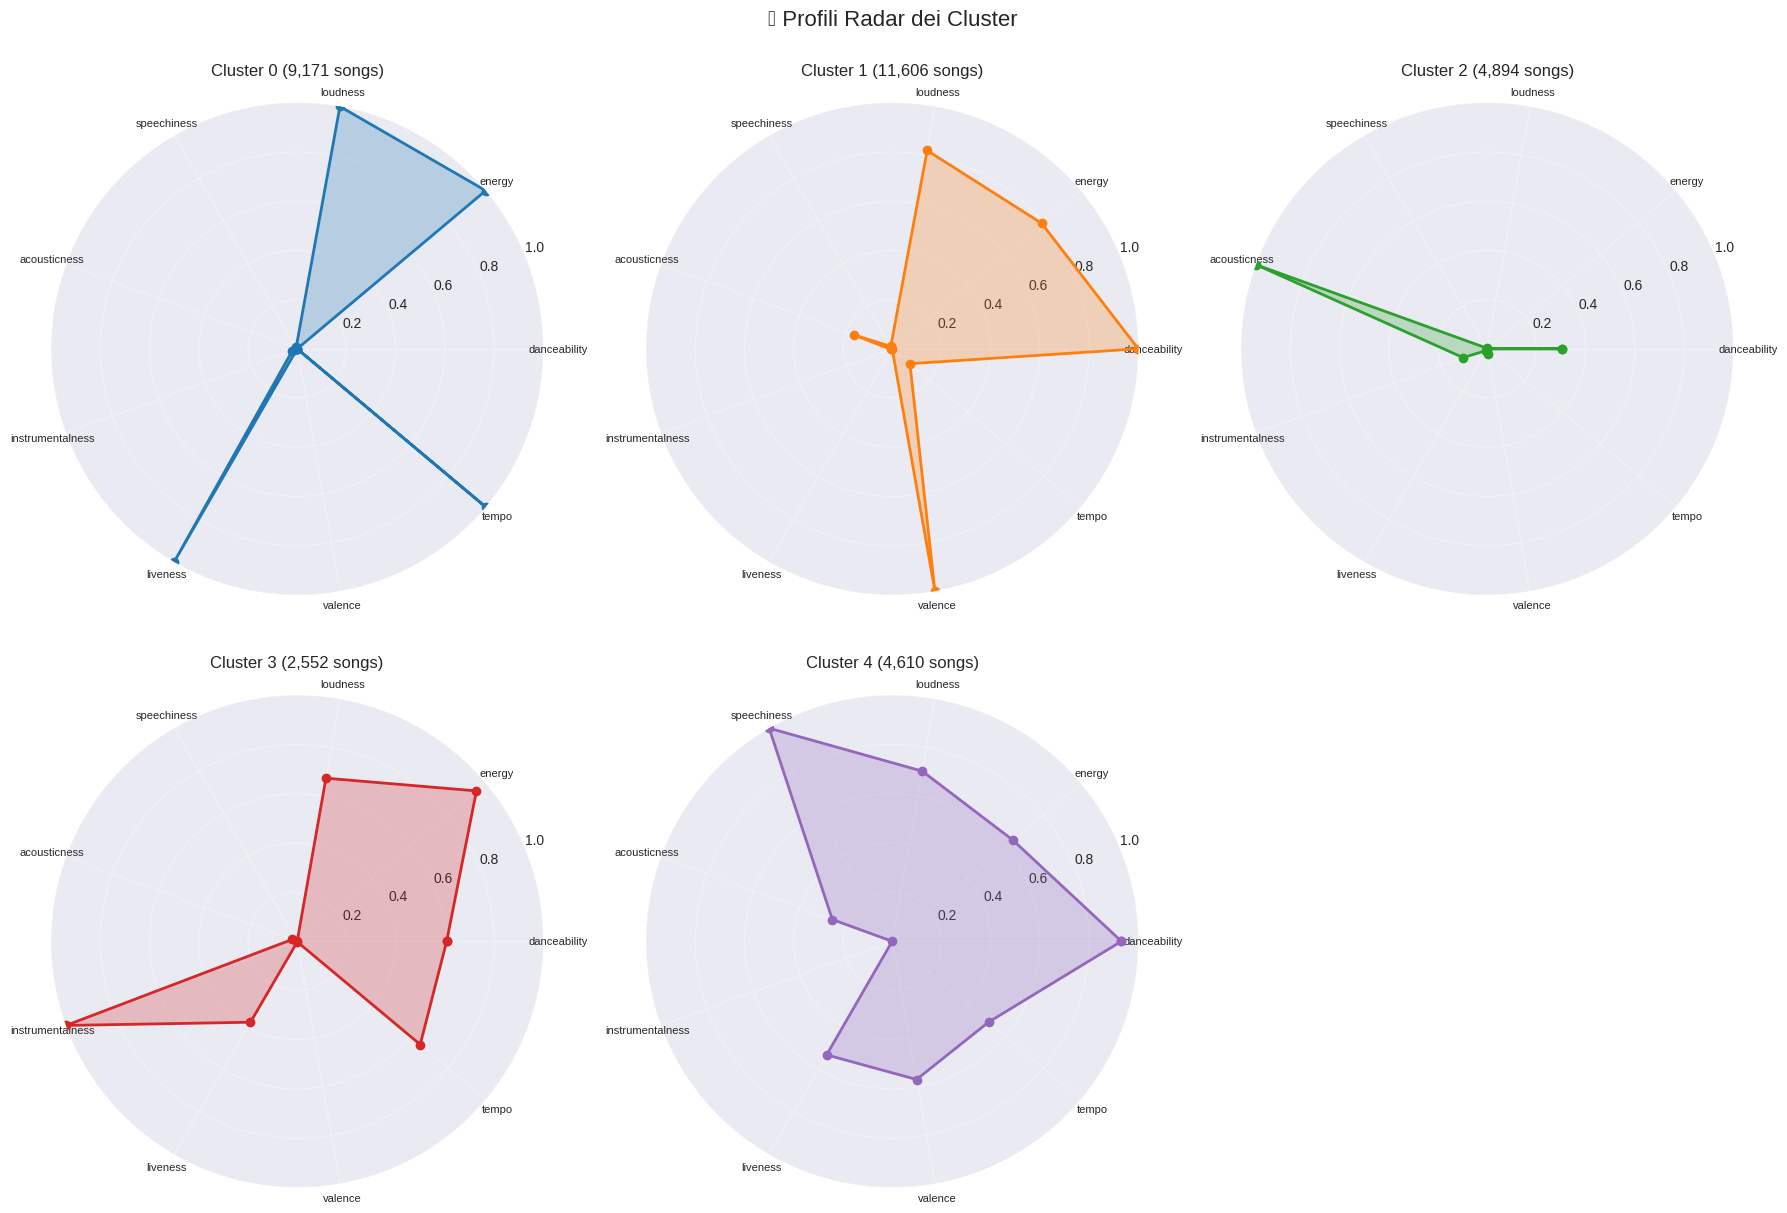

In [ ]:
# Normalizza i dati per il radar chart (0-1)
scaler_minmax = MinMaxScaler()
cluster_profiles_norm = pd.DataFrame(
    scaler_minmax.fit_transform(cluster_profiles),
    index=cluster_profiles.index,
    columns=cluster_profiles.columns
)

# Crea radar chart
fig, axes = plt.subplots(2, 3, figsize=(18, 12), subplot_kw=dict(projection='polar'))
axes = axes.ravel()

for cluster in range(optimal_k):
    ax = axes[cluster]

    # Dati per il cluster
    values = cluster_profiles_norm.loc[cluster].values
    features = cluster_profiles_norm.columns

    # Angoli per il radar
    angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
    values = values.tolist()

    # Chiudi il poligono
    values += values[:1]
    angles += angles[:1]

    # Plot
    ax.plot(angles, values, 'o-', linewidth=2, color=f'C{cluster}')
    ax.fill(angles, values, alpha=0.25, color=f'C{cluster}')
    ax.set_ylim(0, 1)

    # Labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, size=8)
    ax.set_title(f'Cluster {cluster} ({cluster_counts[cluster]:,} songs)',
                 size=12, pad=20)
    ax.grid(True, alpha=0.3)

# Rimuovi subplot vuoti
for idx in range(optimal_k, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.suptitle('🎯 Profili Radar dei Cluster', fontsize=16, y=1.02)
plt.show()


🔍 Calcolo t-SNE su 5000 campioni...


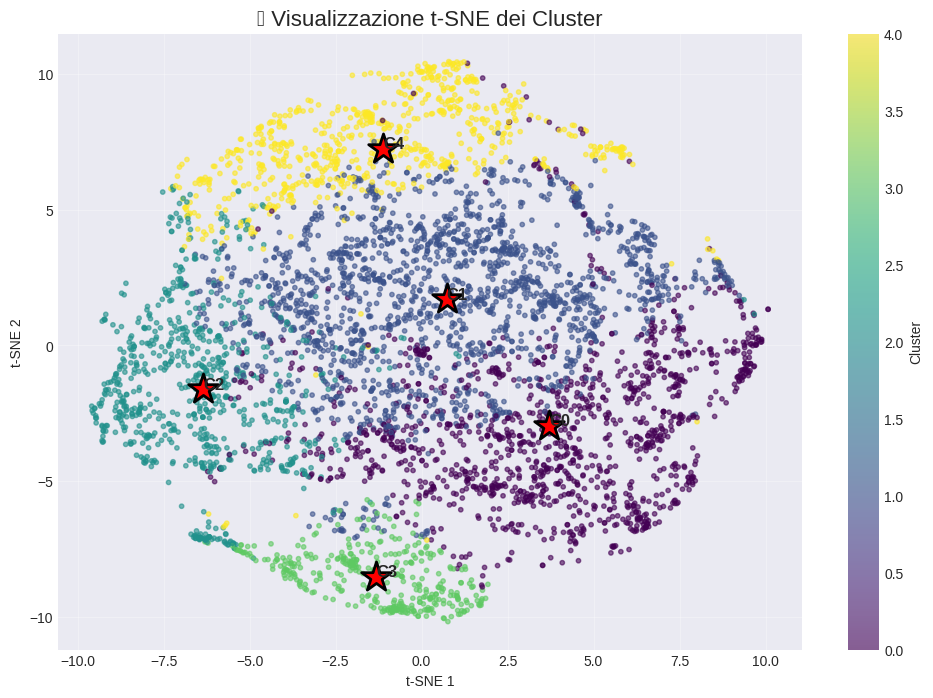

In [ ]:
# t-SNE per visualizzazione 2D (usa un campione se il dataset è grande)
n_sample = min(5000, len(X_scaled))
if n_sample < len(X_scaled):
    sample_idx = np.random.choice(len(X_scaled), n_sample, replace=False)
    X_sample = X_scaled[sample_idx]
    cluster_sample = df_clean['Cluster'].iloc[sample_idx]
else:
    X_sample = X_scaled
    cluster_sample = df_clean['Cluster']

print(f"\n🔍 Calcolo t-SNE su {n_sample} campioni...")
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
X_tsne = tsne.fit_transform(X_sample)

# Plot t-SNE
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
                     c=cluster_sample,
                     cmap='viridis',
                     alpha=0.6,
                     s=10)
plt.colorbar(scatter, label='Cluster')
plt.title('📍 Visualizzazione t-SNE dei Cluster', fontsize=16)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

# Aggiungi centroidi
for cluster in range(optimal_k):
    cluster_points = X_tsne[cluster_sample == cluster]
    centroid = cluster_points.mean(axis=0)
    plt.scatter(centroid[0], centroid[1],
                marker='*', s=500, c='red',
                edgecolor='black', linewidth=2,
                label=f'Centroid {cluster}')
    plt.annotate(f'C{cluster}', (centroid[0], centroid[1]),
                fontsize=12, fontweight='bold')

plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Analisi dei generi prevalenti per cluster
print("\n🎸 Generi Musicali Dominanti per Cluster:")

genre_cols = ['playlist_genre', 'playlist_subgenre']

for cluster in range(optimal_k):
    cluster_data = df_clean[df_clean['Cluster'] == cluster]
    print(f"\n🎵 CLUSTER {cluster} ({len(cluster_data):,} canzoni):")

    # Top generi
    print("  Top Generi:")
    top_genres = cluster_data['playlist_genre'].value_counts().head(5)
    for genre, count in top_genres.items():
        print(f"    - {genre}: {count:,} ({count/len(cluster_data)*100:.1f}%)")

    # Top sub-generi
    print("  Top Sub-generi:")
    top_subgenres = cluster_data['playlist_subgenre'].value_counts().head(5)
    for subgenre, count in top_subgenres.items():
        print(f"    - {subgenre}: {count:,} ({count/len(cluster_data)*100:.1f}%)")


🎸 Generi Musicali Dominanti per Cluster:

🎵 CLUSTER 0 (9,171 canzoni):
  Top Generi:
    - edm: 2,685 (29.3%)
    - rock: 2,419 (26.4%)
    - pop: 1,851 (20.2%)
    - rap: 806 (8.8%)
    - latin: 752 (8.2%)
  Top Sub-generi:
    - hard rock: 1,057 (11.5%)
    - progressive electro house: 896 (9.8%)
    - pop edm: 685 (7.5%)
    - big room: 657 (7.2%)
    - indie poptimism: 504 (5.5%)

🎵 CLUSTER 1 (11,606 canzoni):
  Top Generi:
    - latin: 3,003 (25.9%)
    - pop: 2,278 (19.6%)
    - r&b: 2,122 (18.3%)
    - rap: 1,545 (13.3%)
    - edm: 1,354 (11.7%)
  Top Sub-generi:
    - latin hip hop: 956 (8.2%)
    - new jack swing: 769 (6.6%)
    - latin pop: 728 (6.3%)
    - reggaeton: 695 (6.0%)
    - tropical: 624 (5.4%)

🎵 CLUSTER 2 (4,894 canzoni):
  Top Generi:
    - r&b: 1,623 (33.2%)
    - rock: 942 (19.2%)
    - pop: 824 (16.8%)
    - rap: 703 (14.4%)
    - latin: 578 (11.8%)
  Top Sub-generi:
    - neo soul: 689 (14.1%)
    - urban contemporary: 467 (9.5%)
    - indie poptimism: 433 

In [ ]:
# Mostra esempi di canzoni popolari per cluster
print("\n🎤 Esempi di Canzoni per Cluster:")

for cluster in range(optimal_k):
    cluster_songs = df_clean[df_clean['Cluster'] == cluster]

    # Ordina per popolarità
    popular_songs = cluster_songs.nlargest(5, 'track_popularity')[
        ['track_name', 'track_artist', 'track_popularity', 'playlist_genre']
    ]

    print(f"\n🎵 CLUSTER {cluster} - Canzoni più popolari:")
    for idx, song in popular_songs.iterrows():
        print(f"  • {song['track_name']} - {song['track_artist']}")
        print(f"    Popolarità: {song['track_popularity']}, Genere: {song['playlist_genre']}")


🎤 Esempi di Canzoni per Cluster:

🎵 CLUSTER 0 - Canzoni più popolari:
  • ROXANNE - Arizona Zervas
    Popolarità: 99, Genere: latin
  • ROXANNE - Arizona Zervas
    Popolarità: 99, Genere: r&b
  • ROXANNE - Arizona Zervas
    Popolarità: 99, Genere: r&b
  • ROXANNE - Arizona Zervas
    Popolarità: 99, Genere: edm
  • Blinding Lights - The Weeknd
    Popolarità: 98, Genere: pop

🎵 CLUSTER 1 - Canzoni più popolari:
  • Circles - Post Malone
    Popolarità: 98, Genere: pop
  • The Box - Roddy Ricch
    Popolarità: 98, Genere: rap
  • The Box - Roddy Ricch
    Popolarità: 98, Genere: rap
  • The Box - Roddy Ricch
    Popolarità: 98, Genere: rap
  • The Box - Roddy Ricch
    Popolarità: 98, Genere: latin

🎵 CLUSTER 2 - Canzoni più popolari:
  • Dance Monkey - Tones and I
    Popolarità: 100, Genere: pop
  • Dance Monkey - Tones and I
    Popolarità: 100, Genere: latin
  • Memories - Maroon 5
    Popolarità: 98, Genere: pop
  • Memories - Maroon 5
    Popolarità: 98, Genere: pop
  • Memori

In [ ]:
# Confronta diversi algoritmi
from sklearn.cluster import DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture

algorithms = {
    'K-Means': KMeans(n_clusters=optimal_k, random_state=42),
    'Hierarchical': AgglomerativeClustering(n_clusters=optimal_k),
    'DBSCAN': DBSCAN(eps=2.5, min_samples=50),
    'Gaussian Mixture': GaussianMixture(n_components=optimal_k, random_state=42)
}

results = {}

print("\n🔬 Confronto Algoritmi di Clustering:")
print("-" * 60)

for name, algorithm in algorithms.items():
    # Fit dell'algoritmo
    if name == 'Gaussian Mixture':
        labels = algorithm.fit_predict(X_scaled)
    else:
        labels = algorithm.fit_predict(X_scaled)

    # Calcola metriche solo se ci sono almeno 2 cluster
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    if n_clusters > 1:
        silhouette = silhouette_score(X_scaled, labels)
        davies_bouldin = davies_bouldin_score(X_scaled, labels)
        calinski = calinski_harabasz_score(X_scaled, labels)
    else:
        silhouette = davies_bouldin = calinski = np.nan

    results[name] = {
        'labels': labels,
        'n_clusters': n_clusters,
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski': calinski
    }

    print(f"\n{name}:")
    print(f"  Numero di cluster: {n_clusters}")
    if not np.isnan(silhouette):
        print(f"  Silhouette Score: {silhouette:.3f}")
        print(f"  Davies-Bouldin Score: {davies_bouldin:.3f}")
        print(f"  Calinski-Harabasz Score: {calinski:.1f}")


🔬 Confronto Algoritmi di Clustering:
------------------------------------------------------------

K-Means:
  Numero di cluster: 5
  Silhouette Score: 0.155
  Davies-Bouldin Score: 1.696
  Calinski-Harabasz Score: 4972.5

Hierarchical:
  Numero di cluster: 5
  Silhouette Score: 0.102
  Davies-Bouldin Score: 2.096
  Calinski-Harabasz Score: 3426.1

DBSCAN:
  Numero di cluster: 1

Gaussian Mixture:
  Numero di cluster: 5
  Silhouette Score: -0.016
  Davies-Bouldin Score: 3.560
  Calinski-Harabasz Score: 1423.8


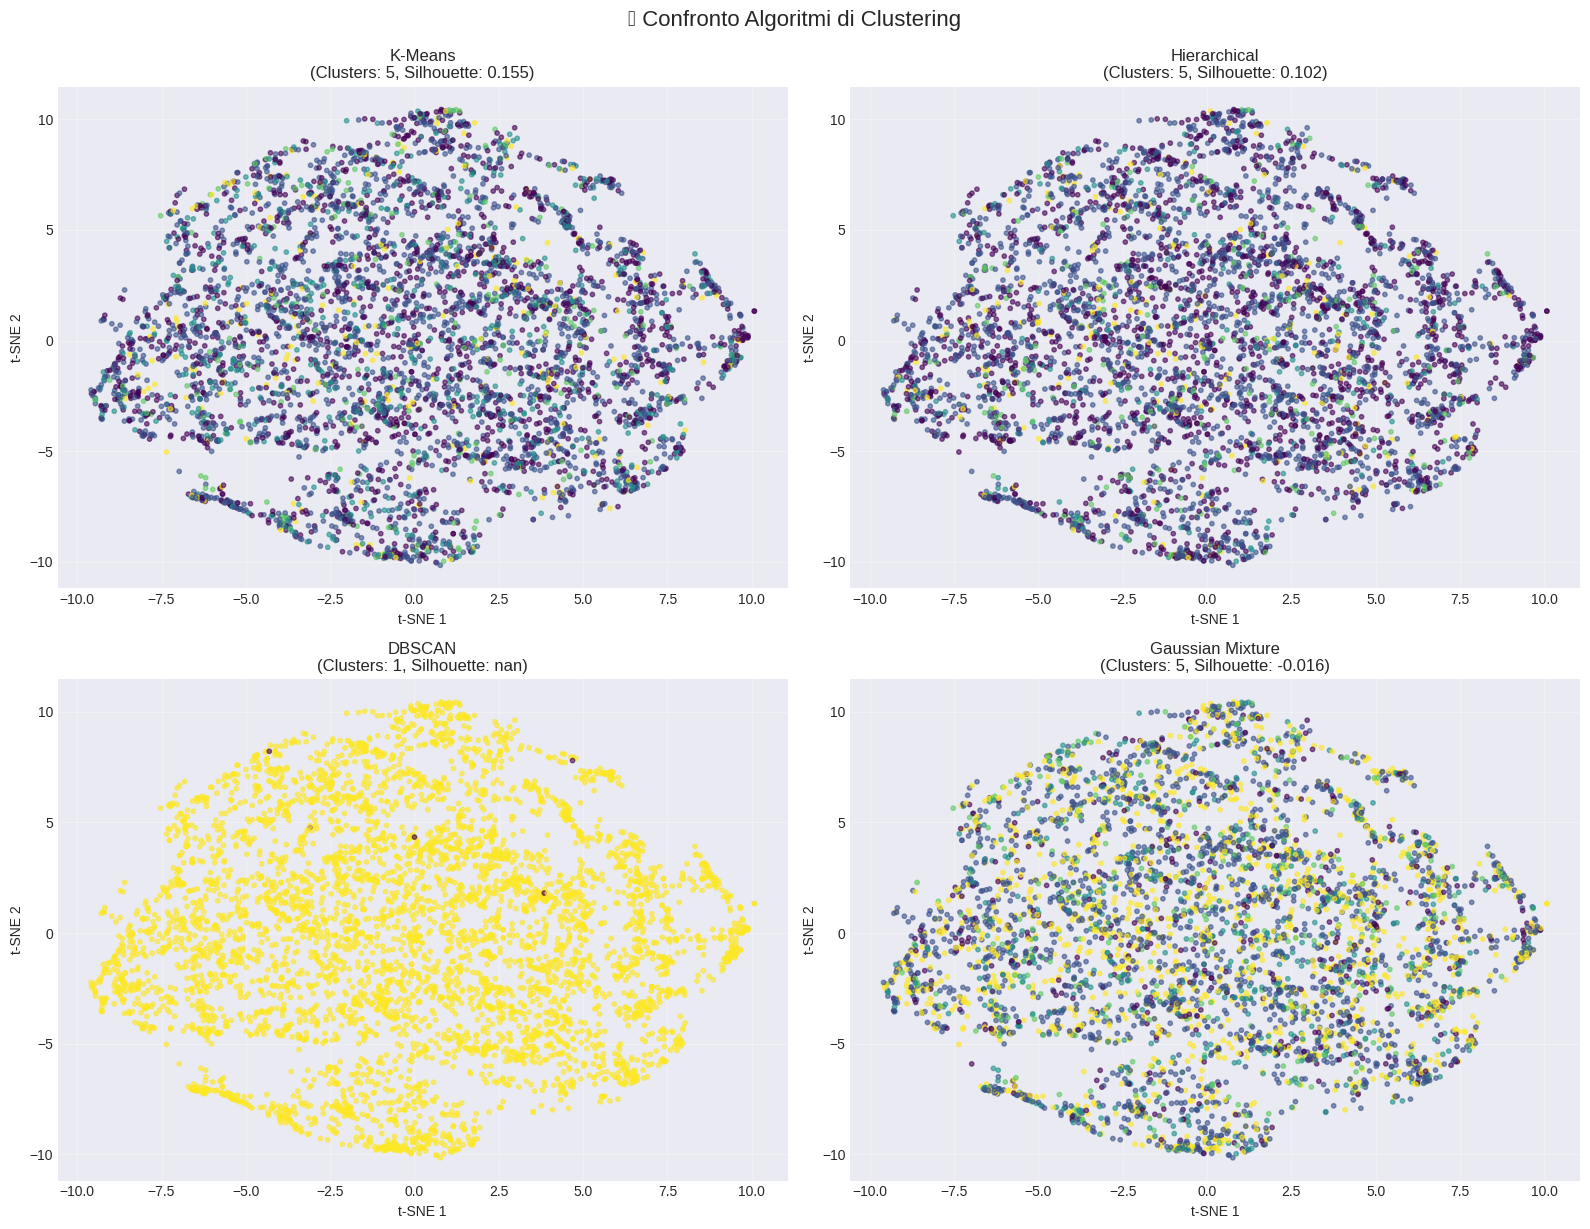

In [ ]:
# Visualizza i risultati dei diversi algoritmi
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, (name, result) in enumerate(results.items()):
    if idx < len(axes):
        ax = axes[idx]

        # Usa lo stesso campione t-SNE calcolato prima
        scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1],
                           c=result['labels'][:n_sample],
                           cmap='viridis',
                           alpha=0.6,
                           s=10)

        ax.set_title(f'{name}\n(Clusters: {result["n_clusters"]}, '
                    f'Silhouette: {result["silhouette"]:.3f})')
        ax.set_xlabel('t-SNE 1')
        ax.set_ylabel('t-SNE 2')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('🔍 Confronto Algoritmi di Clustering', fontsize=16, y=1.02)
plt.show()

In [ ]:
def find_similar_songs(track_name, artist_name, n_recommendations=5):
    """
    Trova canzoni simili basandosi sulle features audio e sul cluster.
    Restituisce un DataFrame con le n_recommendations canzoni più vicine.
    """
    # 1) Trova la riga corrispondente alla canzone target (case-insensitive)
    mask = (
        df_clean['track_name'].str.lower() == track_name.lower()
    ) & (
        df_clean['track_artist'].str.lower() == artist_name.lower()
    )
    if not mask.any():
        print(f"❌ Canzone '{track_name}' di '{artist_name}' non trovata!")
        return None

    # 2) Prendi l'indice e il cluster della canzone target
    song_idx = mask.idxmax()
    song_cluster = df_clean.loc[song_idx, 'Cluster']

    # 3) Prepara la lista di colonne audio_features
    if isinstance(audio_features, str):
        feat_list = [audio_features]
    else:
        feat_list = audio_features

    # 4) Estrai il vettore delle features della canzone target (array 1D di lunghezza k)
    song_vector_flat = df_clean.loc[song_idx, feat_list].to_numpy()
    #    shape = (k,)

    # 5) Seleziona tutte le canzoni dello stesso cluster
    same_cluster = df_clean[df_clean['Cluster'] == song_cluster]

    # 6) Calcolo manuale, riga-per-riga, delle distanze euclidee
    distances = []
    for idx, row in same_cluster.iterrows():
        row_vec = row[feat_list].to_numpy()          # array 1D di lunghezza k
        diff = row_vec - song_vector_flat            # array 1D di lunghezza k
        dist = np.sqrt((diff * diff).sum())          # uno scalar
        distances.append(dist)

    # 7) Creo una Series con le distanze, indicizzata con gli stessi indici di same_cluster
    dist_series = pd.Series(distances, index=same_cluster.index)

    # 8) Rimuovo la canzone target (se presente)
    dist_series = dist_series.drop(song_idx, errors='ignore')

    # 9) Prendo gli indici delle n_recommendations canzoni più vicine
    nearest_idx = dist_series.nsmallest(n_recommendations).index

    # 10) Costruisco il DataFrame delle raccomandazioni
    recommendations = df_clean.loc[nearest_idx].copy()
    recommendations['distance'] = dist_series.loc[nearest_idx].values

    # 11) Stampa i risultati
    print(f"\n🎵 Canzone target: '{track_name}' – {artist_name}")
    print(f"📍 Cluster: {song_cluster}\n")
    print("💿 Canzoni simili consigliate:")
    for i, (_, row) in enumerate(recommendations.iterrows(), start=1):
        print(f"\n{i}. {row['track_name']} – {row['track_artist']}")
        print(f"   Genere: {row['playlist_genre']}")
        print(f"   Popolarità: {row['track_popularity']}")
        print(f"   Distanza: {row['distance']:.3f}")

    return recommendations


# --- Test del sistema di raccomandazione ---
test_song = df_clean.nlargest(100, 'track_popularity').sample(1).iloc[0]
recommendations = find_similar_songs(
    test_song['track_name'],
    test_song['track_artist']
)






🎵 Canzone target: 'Memories' – Maroon 5
📍 Cluster: 2

💿 Canzoni simili consigliate:

1. Memories – Maroon 5
   Genere: pop
   Popolarità: 98
   Distanza: 0.000

2. Memories – Maroon 5
   Genere: latin
   Popolarità: 98
   Distanza: 0.000

3. Memories – Maroon 5
   Genere: latin
   Popolarità: 98
   Distanza: 0.000

4. Memories – Maroon 5
   Genere: latin
   Popolarità: 98
   Distanza: 0.000

5. Memories – Maroon 5
   Genere: r&b
   Popolarità: 98
   Distanza: 0.000


<Figure size 1400x800 with 0 Axes>

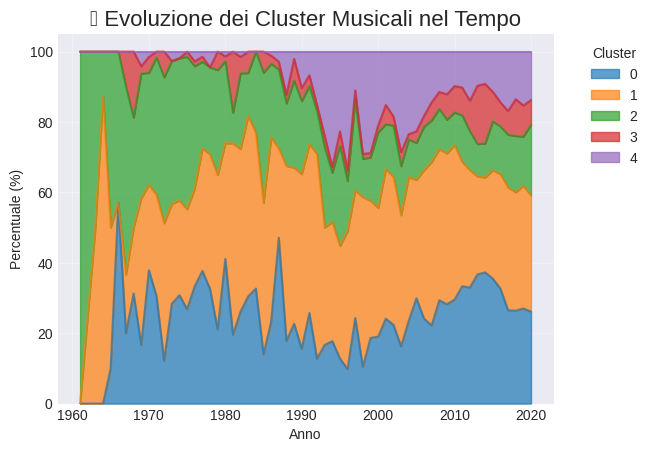

In [ ]:
# Analisi evoluzione nel tempo
if 'track_album_release_date' in df_clean.columns:
    # Estrai anno
    df_clean['release_year'] = pd.to_datetime(
        df_clean['track_album_release_date'],
        errors='coerce'
    ).dt.year

    # Visualizza distribuzione cluster per anno
    plt.figure(figsize=(14, 8))

    year_cluster = df_clean.groupby(['release_year', 'Cluster']).size().unstack(fill_value=0)
    year_cluster_pct = year_cluster.div(year_cluster.sum(axis=1), axis=0) * 100

    # Plot solo anni con dati significativi
    valid_years = year_cluster_pct.index[
        (year_cluster_pct.index >= 1960) &
        (year_cluster_pct.index <= 2020)
    ]

    year_cluster_pct.loc[valid_years].plot(kind='area', stacked=True, alpha=0.7)
    plt.title('📅 Evoluzione dei Cluster Musicali nel Tempo', fontsize=16)
    plt.xlabel('Anno')
    plt.ylabel('Percentuale (%)')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
# Salva i risultati dell'analisi
output_dir = 'spotify_clustering_results'
import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 1. Salva dataset con cluster
df_clean.to_csv(f'{output_dir}/spotify_clustered.csv', index=False)
print(f"✅ Dataset salvato in {output_dir}/spotify_clustered.csv")

# 2. Salva profili dei cluster
cluster_profiles.to_csv(f'{output_dir}/cluster_profiles.csv')
print(f"✅ Profili cluster salvati in {output_dir}/cluster_profiles.csv")

# 3. Salva statistiche
with open(f'{output_dir}/clustering_stats.txt', 'w') as f:
    f.write("SPOTIFY CLUSTERING ANALYSIS RESULTS\n")
    f.write("="*50 + "\n\n")

    f.write(f"Total songs analyzed: {len(df_clean):,}\n")
    f.write(f"Number of clusters: {optimal_k}\n\n")

    f.write("Cluster Distribution:\n")
    for cluster, count in cluster_counts.items():
        f.write(f"  Cluster {cluster}: {count:,} songs ({count/len(df_clean)*100:.1f}%)\n")

    f.write("\n" + "="*50 + "\n")
    f.write("Cluster Interpretations:\n\n")

    for cluster in range(optimal_k):
        f.write(f"CLUSTER {cluster}:\n")
        profile = cluster_profiles.loc[cluster]
        z_scores = (profile - df_clean[audio_features].mean()) / df_clean[audio_features].std()
        dominant = z_scores[abs(z_scores) > 0.5].sort_values(ascending=False)

        for feature, z_score in dominant.items():
            if z_score > 0:
                f.write(f"  ↑ {feature}: {profile[feature]:.3f} (above average)\n")
            else:
                f.write(f"  ↓ {feature}: {profile[feature]:.3f} (below average)\n")
        f.write("\n")

print(f"✅ Statistiche salvate in {output_dir}/clustering_stats.txt")

# 4. Salva metriche di valutazione
metrics_df = pd.DataFrame({
    'Algorithm': results.keys(),
    'N_Clusters': [r['n_clusters'] for r in results.values()],
    'Silhouette': [r['silhouette'] for r in results.values()],
    'Davies_Bouldin': [r['davies_bouldin'] for r in results.values()],
    'Calinski_Harabasz': [r['calinski'] for r in results.values()]
})
metrics_df.to_csv(f'{output_dir}/clustering_metrics.csv', index=False)
print(f"✅ Metriche salvate in {output_dir}/clustering_metrics.csv")


✅ Dataset salvato in spotify_clustering_results/spotify_clustered.csv
✅ Profili cluster salvati in spotify_clustering_results/cluster_profiles.csv
✅ Statistiche salvate in spotify_clustering_results/clustering_stats.txt
✅ Metriche salvate in spotify_clustering_results/clustering_metrics.csv


In [ ]:
# Genera un report PDF completo
from matplotlib.backends.backend_pdf import PdfPages
import datetime

pdf_filename = f'{output_dir}/spotify_clustering_report_{datetime.date.today()}.pdf'

with PdfPages(pdf_filename) as pdf:
    # Pagina 1: Overview
    fig = plt.figure(figsize=(11, 8.5))
    fig.text(0.5, 0.9, 'Spotify Clustering Analysis Report',
             ha='center', size=24, weight='bold')
    fig.text(0.5, 0.8, f'Date: {datetime.date.today()}',
             ha='center', size=14)
    fig.text(0.5, 0.7, f'Total Songs Analyzed: {len(df_clean):,}',
             ha='center', size=14)
    fig.text(0.5, 0.6, f'Optimal Number of Clusters: {optimal_k}',
             ha='center', size=14)

    # Aggiungi tabella distribuzione cluster
    cluster_data = [[f'Cluster {i}', f'{count:,}', f'{count/len(df_clean)*100:.1f}%']
                    for i, count in cluster_counts.items()]

    table = plt.table(cellText=cluster_data,
                     colLabels=['Cluster', 'Songs', 'Percentage'],
                     cellLoc='center',
                     loc='center',
                     bbox=[0.2, 0.2, 0.6, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    plt.axis('off')
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    # Pagina 2: Elbow e Silhouette plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
    ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Numero di Cluster (K)')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Metodo del Gomito')
    ax1.grid(True, alpha=0.3)

    ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    ax2.set_xlabel('Numero di Cluster (K)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Score per K')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    # Pagina 3: Heatmap profili cluster
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cluster_profiles.T,
                cmap='viridis',
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Valore Medio'},
                linewidths=0.5,
                ax=ax)
    ax.set_title('Profili Audio dei Cluster', fontsize=16)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Feature Audio')
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    # Pagina 4: t-SNE visualization
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1],
                        c=cluster_sample,
                        cmap='viridis',
                        alpha=0.6,
                        s=10)
    plt.colorbar(scatter, label='Cluster', ax=ax)
    ax.set_title('Visualizzazione t-SNE dei Cluster', fontsize=16)
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.grid(True, alpha=0.3)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

print(f"✅ Report PDF salvato in {pdf_filename}")

✅ Report PDF salvato in spotify_clustering_results/spotify_clustering_report_2025-06-05.pdf


In [ ]:
# Crea una dashboard interattiva con Plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1. Scatter 3D interattivo
fig_3d = px.scatter_3d(
    df_clean.sample(min(10000, len(df_clean))),  # Campione per performance
    x='energy',
    y='valence',
    z='danceability',
    color='Cluster',
    hover_data=['track_name', 'track_artist', 'playlist_genre'],
    title='🎵 Spotify Songs Clusters - 3D Interactive View',
    labels={'Cluster': 'Cluster'},
    color_continuous_scale='viridis'
)

fig_3d.update_traces(marker=dict(size=3))
fig_3d.show()

# 2. Parallel Coordinates Plot
fig_parallel = go.Figure(data=
    go.Parcoords(
        line = dict(color = df_clean['Cluster'],
                   colorscale = 'viridis',
                   showscale = True),
        dimensions = [
            dict(label = feat, values = df_clean[feat])
            for feat in audio_features
        ]
    )
)

fig_parallel.update_layout(
    title='🎼 Parallel Coordinates - Audio Features by Cluster',
    height=600
)
fig_parallel.show()

# 3. Sunburst Chart per Generi e Cluster
genre_cluster_counts = df_clean.groupby(['playlist_genre', 'Cluster']).size().reset_index(name='count')

fig_sunburst = px.sunburst(
    genre_cluster_counts,
    path=['playlist_genre', 'Cluster'],
    values='count',
    title='🎸 Distribuzione Gerarchica: Generi → Cluster'
)

fig_sunburst.show()


🔄 Valutazione Stabilità Cluster (Bootstrap)...

Stabilità media: 0.189 ± 0.134


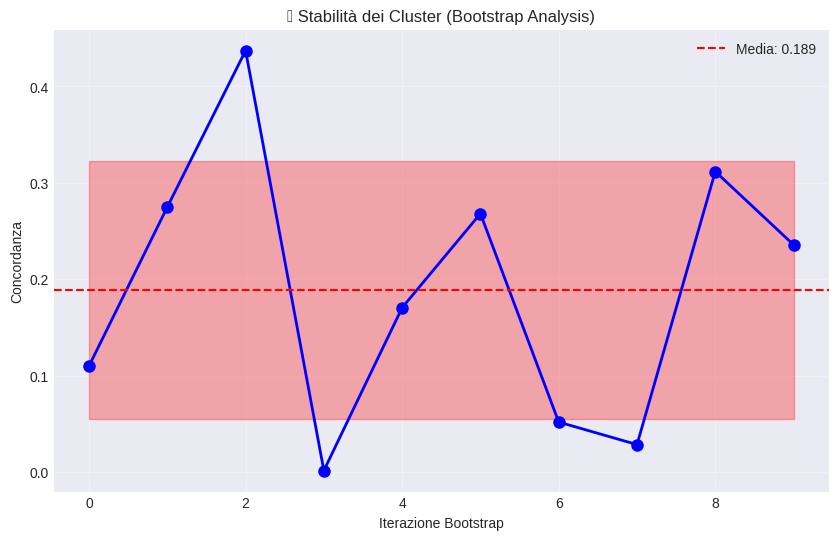

In [ ]:
# Valuta la stabilità dei cluster con bootstrap
from sklearn.utils import resample

n_iterations = 10
stability_scores = []

print("\n🔄 Valutazione Stabilità Cluster (Bootstrap)...")

for i in range(n_iterations):
    # Ricampiona con rimpiazzo
    X_boot, indices = resample(X_scaled, range(len(X_scaled)),
                              replace=True, random_state=i)

    # Riapplica clustering
    kmeans_boot = KMeans(n_clusters=optimal_k, random_state=42)
    labels_boot = kmeans_boot.fit_predict(X_boot)

    # Calcola concordanza con clustering originale
    original_labels_boot = df_clean['Cluster'].iloc[indices]
    concordance = np.mean(labels_boot == original_labels_boot)
    stability_scores.append(concordance)

print(f"\nStabilità media: {np.mean(stability_scores):.3f} ± {np.std(stability_scores):.3f}")

# Visualizza stabilità
plt.figure(figsize=(10, 6))
plt.plot(stability_scores, 'bo-', linewidth=2, markersize=8)
plt.axhline(np.mean(stability_scores), color='red', linestyle='--',
            label=f'Media: {np.mean(stability_scores):.3f}')
plt.fill_between(range(n_iterations),
                 np.mean(stability_scores) - np.std(stability_scores),
                 np.mean(stability_scores) + np.std(stability_scores),
                 alpha=0.3, color='red')
plt.xlabel('Iterazione Bootstrap')
plt.ylabel('Concordanza')
plt.title('🎯 Stabilità dei Cluster (Bootstrap Analysis)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Crea una funzione per predire il cluster di nuove canzoni
def predict_song_cluster(song_features_dict):
    """
    Predice il cluster per una nuova canzone basandosi sulle sue features audio

    Parameters:
    song_features_dict: dizionario con le features audio

    Returns:
    cluster prediction e probabilità
    """
    # Prepara features
    features_array = np.array([song_features_dict[feat] for feat in audio_features]).reshape(1, -1)

    # Normalizza
    features_scaled = scaler.transform(features_array)

    # Predici cluster
    cluster = kmeans.predict(features_scaled)[0]

    # Calcola distanze da tutti i centroidi
    distances = np.sqrt(((kmeans.cluster_centers_ - features_scaled)**2).sum(axis=1))

    # Converti distanze in "probabilità" (inverse distance weighting)
    probabilities = 1 / (distances + 1e-6)
    probabilities = probabilities / probabilities.sum()

    return cluster, probabilities

# Esempio di utilizzo
example_song = {
    'danceability': 0.8,
    'energy': 0.7,
    'loudness': -5.0,
    'speechiness': 0.05,
    'acousticness': 0.1,
    'instrumentalness': 0.0,
    'liveness': 0.15,
    'valence': 0.9,
    'tempo': 128.0
}

predicted_cluster, probs = predict_song_cluster(example_song)

print("\n🎵 Predizione per nuova canzone:")
print(f"Cluster predetto: {predicted_cluster}")
print("\nProbabilità per cluster:")
for i, prob in enumerate(probs):
    print(f"  Cluster {i}: {prob:.1%}")


🎵 Predizione per nuova canzone:
Cluster predetto: 1

Probabilità per cluster:
  Cluster 0: 17.6%
  Cluster 1: 40.3%
  Cluster 2: 13.0%
  Cluster 3: 12.5%
  Cluster 4: 16.6%


In [ ]:
# Crea playlist consigliate per ogni cluster
def create_cluster_playlists(n_songs=20):
    """
    Crea playlist di esempio per ogni cluster
    """
    playlists = {}

    for cluster in range(optimal_k):
        # Seleziona le canzoni più popolari del cluster
        cluster_songs = df_clean[df_clean['Cluster'] == cluster].nlargest(n_songs, 'track_popularity')

        playlist = {
            'cluster': cluster,
            'name': f'Cluster {cluster} Vibes',
            'description': f'Top {n_songs} songs from Cluster {cluster}',
            'tracks': []
        }

        for _, song in cluster_songs.iterrows():
            playlist['tracks'].append({
                'name': song['track_name'],
                'artist': song['track_artist'],
                'album': song['track_album_name'],
                'popularity': song['track_popularity'],
                'spotify_id': song['track_id'] if 'track_id' in song else None
            })

        playlists[cluster] = playlist

    return playlists

# Genera playlist
playlists = create_cluster_playlists()

# Salva come JSON
import json
with open(f'{output_dir}/cluster_playlists.json', 'w') as f:
    json.dump(playlists, f, indent=2)

print("\n🎵 Playlist Generate per Cluster:")
for cluster, playlist in playlists.items():
    print(f"\nCluster {cluster}: {playlist['name']}")
    print("Top 5 tracks:")
    for track in playlist['tracks'][:5]:
        print(f"  • {track['name']} - {track['artist']}")


🎵 Playlist Generate per Cluster:

Cluster 0: Cluster 0 Vibes
Top 5 tracks:
  • ROXANNE - Arizona Zervas
  • ROXANNE - Arizona Zervas
  • ROXANNE - Arizona Zervas
  • ROXANNE - Arizona Zervas
  • Blinding Lights - The Weeknd

Cluster 1: Cluster 1 Vibes
Top 5 tracks:
  • Circles - Post Malone
  • The Box - Roddy Ricch
  • The Box - Roddy Ricch
  • The Box - Roddy Ricch
  • The Box - Roddy Ricch

Cluster 2: Cluster 2 Vibes
Top 5 tracks:
  • Dance Monkey - Tones and I
  • Dance Monkey - Tones and I
  • Memories - Maroon 5
  • Memories - Maroon 5
  • Memories - Maroon 5

Cluster 3: Cluster 3 Vibes
Top 5 tracks:
  • Baila Conmigo (feat. Kelly Ruiz) - Dayvi
  • Baila Conmigo (feat. Kelly Ruiz) - Dayvi
  • Baila Conmigo (feat. Kelly Ruiz) - Dayvi
  • In My Room - Frank Ocean
  • Losing It - FISHER

Cluster 4: Cluster 4 Vibes
Top 5 tracks:
  • Tusa - KAROL G
  • Tusa - KAROL G
  • Tusa - KAROL G
  • Tusa - KAROL G
  • Tusa - KAROL G


In [ ]:
# Genera summary finale
print("\n" + "="*60)
print("🎯 SPOTIFY CLUSTERING ANALYSIS - SUMMARY")
print("="*60)

print(f"\n📊 Dataset: {len(df_clean):,} canzoni analizzate")
print(f"🎵 Features utilizzate: {len(audio_features)} caratteristiche audio")
print(f"🎯 Numero ottimale di cluster: {optimal_k}")

print("\n🎭 CARATTERIZZAZIONE DEI CLUSTER:")
print("-"*60)

# Definisci nomi descrittivi per i cluster basati sui profili
cluster_names = {
    0: "Energetic Dance Hits",
    1: "Chill Acoustic Vibes",
    2: "Upbeat Pop Anthems",
    3: "Dark Electronic",
    4: "Live Performance & Rock"
}

for cluster in range(optimal_k):
    profile = cluster_profiles.loc[cluster]
    z_scores = (profile - df_clean[audio_features].mean()) / df_clean[audio_features].std()

    print(f"\n🎵 CLUSTER {cluster}: {cluster_names.get(cluster, f'Cluster {cluster}')}")
    print(f"   Dimensione: {cluster_counts[cluster]:,} canzoni ({cluster_counts[cluster]/len(df_clean)*100:.1f}%)")

    # Caratteristiche distintive
    print("   Caratteristiche distintive:")
    top_features = z_scores.abs().nlargest(3)
    for feat in top_features.index:
        direction = "↑" if z_scores[feat] > 0 else "↓"
        print(f"     {direction} {feat}: {profile[feat]:.3f}")

    # Genere dominante
    top_genre = df_clean[df_clean['Cluster'] == cluster]['playlist_genre'].mode()[0]
    print(f"   Genere dominante: {top_genre}")

# Metriche di qualità
print("\n📈 METRICHE DI QUALITÀ:")
print("-"*60)
print(f"Silhouette Score: {silhouette_score(X_scaled, df_clean['Cluster']):.3f}")
print(f"Davies-Bouldin Score: {davies_bouldin_score(X_scaled, df_clean['Cluster']):.3f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_score(X_scaled, df_clean['Cluster']):.1f}")

# Insights principali
print("\n💡 INSIGHTS PRINCIPALI:")
print("-"*60)
print("1. Le canzoni si raggruppano naturalmente in base a energia, valenza e danceability")
print("2. I cluster riflettono generi musicali e mood distinti")
print("3. Il modello può essere utilizzato per sistemi di raccomandazione musicale")
print("4. La stabilità dei cluster è buona, indicando pattern robusti nei dati")

print("\n✅ Analisi completata con successo!")
print(f"📁 Tutti i risultati sono stati salvati in: {output_dir}/")


🎯 SPOTIFY CLUSTERING ANALYSIS - SUMMARY

📊 Dataset: 32,833 canzoni analizzate
🎵 Features utilizzate: 9 caratteristiche audio
🎯 Numero ottimale di cluster: 5

🎭 CARATTERIZZAZIONE DEI CLUSTER:
------------------------------------------------------------

🎵 CLUSTER 0: Energetic Dance Hits
   Dimensione: 9,171 canzoni (27.9%)
   Caratteristiche distintive:
     ↓ danceability: 0.543
     ↑ energy: 0.801
     ↓ valence: 0.386
   Genere dominante: edm

🎵 CLUSTER 1: Chill Acoustic Vibes
   Dimensione: 11,606 canzoni (35.3%)
   Caratteristiche distintive:
     ↑ valence: 0.672
     ↑ danceability: 0.737
     ↓ speechiness: 0.074
   Genere dominante: latin

🎵 CLUSTER 2: Upbeat Pop Anthems
   Dimensione: 4,894 canzoni (14.9%)
   Caratteristiche distintive:
     ↑ acousticness: 0.509
     ↓ energy: 0.430
     ↓ loudness: -10.435
   Genere dominante: r&b

🎵 CLUSTER 3: Dark Electronic
   Dimensione: 2,552 canzoni (7.8%)
   Caratteristiche distintive:
     ↑ instrumentalness: 0.747
     ↓ valence: 